# Chutes and Ladders
By: Andrew Angulo

---

## Dynamic Programming Approach

In [40]:
import numpy as np
import pprint
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


# Setting up the Game

In [41]:
ladders = {1: 38, 4: 14, 9: 31, 21: 42, 36: 44, 51: 67, 71: 91, 28: 84, 80: 100} #To climb closer to the goal
chutes = {16: 6, 49: 11, 47: 26, 87: 24, 56: 53, 64: 60, 93: 73, 95: 75, 98: 78} #Sets you farther away from the goal

# number of states
n = 100
goal_sate = 100

#dices
dices = {'red': {2: 2/3, 6: 1/3},
         'blue': {3: 1.0},
         'green': {1: 1/2, 5: 1/2},
         'black': {0: 1/3, 4: 2/3}}

actions = list(dices.keys()) #name of the dices

In [42]:
def state_after_event(position):
    '''
    Entering a state after being sent either up or down from a chute/ladder
    '''
    while position in ladders or position in chutes:
        if position in ladders:
            position = ladders[position]
        elif position in chutes:
            position = chutes[position]
    return position

# Adding the normal states that have nothing special to them
normal_states = []
for state in range(0, n+1):
    if state == goal_sate:
        normal_states.append(state)
        continue

    if state in chutes or state in ladders:
        continue

    normal_states.append(state)

# Creating final mapping of the entire board game
stable_state_to_index = {s: i for i, s in enumerate(normal_states)}

pprint.pprint(stable_state_to_index)

{0: 0,
 2: 1,
 3: 2,
 5: 3,
 6: 4,
 7: 5,
 8: 6,
 10: 7,
 11: 8,
 12: 9,
 13: 10,
 14: 11,
 15: 12,
 17: 13,
 18: 14,
 19: 15,
 20: 16,
 22: 17,
 23: 18,
 24: 19,
 25: 20,
 26: 21,
 27: 22,
 29: 23,
 30: 24,
 31: 25,
 32: 26,
 33: 27,
 34: 28,
 35: 29,
 37: 30,
 38: 31,
 39: 32,
 40: 33,
 41: 34,
 42: 35,
 43: 36,
 44: 37,
 45: 38,
 46: 39,
 48: 40,
 50: 41,
 52: 42,
 53: 43,
 54: 44,
 55: 45,
 57: 46,
 58: 47,
 59: 48,
 60: 49,
 61: 50,
 62: 51,
 63: 52,
 65: 53,
 66: 54,
 67: 55,
 68: 56,
 69: 57,
 70: 58,
 72: 59,
 73: 60,
 74: 61,
 75: 62,
 76: 63,
 77: 64,
 78: 65,
 79: 66,
 81: 67,
 82: 68,
 83: 69,
 84: 70,
 85: 71,
 86: 72,
 88: 73,
 89: 74,
 90: 75,
 91: 76,
 92: 77,
 94: 78,
 96: 79,
 97: 80,
 99: 81,
 100: 82}


In [43]:
# Getting the probability of dice rolls

def probability(state, action):

    # if the state is in the goal then we can't move anywhere
    if state == goal_sate:
        return {goal_sate: 1.0}
    
    prob = {}

    # were chechking the dice values
    for dice_roll, p in dices[action].items():
        next_state = state + dice_roll
        if next_state >= goal_sate:
            s_prime = goal_sate
        else:
            s_prime = state_after_event(next_state)
        prob[s_prime] = prob.get(s_prime, 0) + p  
    return prob


In [44]:
gamma = 0.9999  # or 0.99, some value less than 1

def matrix(policy):
    num_states = len(normal_states)
    A = np.zeros((num_states, num_states))
    b = np.zeros(num_states)

    for i, s in enumerate(normal_states):
        if s == goal_sate:
            A[i, i] = 1.0
            b[i] = 0.0
        else:
            a = policy[s]
            T = probability(s, a)

            A[i, i] = 1.0
            b[i] = -1.0

            for s_prime, p in T.items():
                j = stable_state_to_index[s_prime]
                A[i, j] -= gamma * p

    V = np.linalg.solve(A, b)
    return V

In [45]:
def local_search(policy):
    stable_initial = stable_state_to_index[0]
    changed = False  # Initialize changed to False at the start
    
    V = matrix(policy)
    base_value = V[stable_initial]

    for s in normal_states:
        if s == goal_sate:
            continue
        current_action = policy[s]
        best_action = current_action
        best_value = base_value
        for a in actions:
            if a == current_action:
                continue
            old_action = policy[s]
            policy[s] = a
            new_V = matrix(policy)
            new_value = new_V[stable_initial]
            if new_value > best_value:
                best_value = new_value
                best_action = a
            policy[s] = old_action
        if best_action != current_action:
            policy[s] = best_action
            changed = True  # Set changed to True when a change is made
    
    return changed  # This will now return False if no changes were made, True if at least one change occurred

In [46]:
def plot_policy(policy):
    """Takes in a policy dictionary (map from state:action) and draws in on the board"""
    grid = np.zeros((10, 10), dtype=int)

    #creates and numbers the base 1-100 grid
    number = 1
    for row in range(10):
        #logic to snake the numbers
        if row % 2 == 0:
            for col in range(10):
                grid[9 - row, col] = number
                number += 1
        else:
            for col in range(9, -1, -1):
                grid[9 - row, col] = number
                number += 1

    #create 2d matrix of colors
    colors = []
    for row in range(10):
        row_colors = []
        for col in range(10):
            cell_number = grid[row, col]
            row_colors.append(policy.get(cell_number, 'grey'))  # Default to grey if not in policy
        colors.append(row_colors)

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_aspect('equal')

    # account for starting square 0. Placed it to the left of the 1st spot outside of the 10x10 grid
    ax.add_patch(
        plt.Rectangle((-1, 9), 1, 1, color=policy.get(0, 'grey'))
    )
    ax.text(
        -0.5, 9.5, '0',
        color='white', ha='center', va='center', fontsize=8
    )

    # actually draw the grid
    for row in range(10):
        for col in range(10):
            ax.add_patch(
                plt.Rectangle((col, row), 1, 1, color=colors[row][col])
            )
            ax.text(
                col + 0.5, row + 0.5, str(grid[row, col]),
                color='white', ha='center', va='center', fontsize=8
            )

    ax.set_xlim(-1, 10)
    ax.set_ylim(0, 10)
    ax.set_xticks([])
    ax.set_yticks([])

    plt.gca().invert_yaxis()
    plt.show()

## Testing Below

In [47]:
policy = {s: 'blue' for s in normal_states}

while True:
    better_action = local_search(policy)
    if not better_action:
        break

final_V = matrix(policy)
print("Best Policy")
for s in sorted(policy.keys()):
    print(f"State {s}: Action {policy[s]}")
print("Value of initial state:", final_V[stable_state_to_index[0]])

Best Policy
State 0: Action black
State 2: Action red
State 3: Action red
State 5: Action blue
State 6: Action blue
State 7: Action red
State 8: Action red
State 10: Action blue
State 11: Action blue
State 12: Action blue
State 13: Action blue
State 14: Action green
State 15: Action black
State 17: Action red
State 18: Action blue
State 19: Action blue
State 20: Action red
State 22: Action red
State 23: Action blue
State 24: Action black
State 25: Action blue
State 26: Action blue
State 27: Action blue
State 29: Action blue
State 30: Action blue
State 31: Action blue
State 32: Action blue
State 33: Action blue
State 34: Action blue
State 35: Action blue
State 37: Action blue
State 38: Action blue
State 39: Action blue
State 40: Action blue
State 41: Action blue
State 42: Action blue
State 43: Action blue
State 44: Action blue
State 45: Action blue
State 46: Action blue
State 48: Action blue
State 50: Action blue
State 52: Action blue
State 53: Action blue
State 54: Action blue
State 55

Best Policy
State 0: Action black
State 2: Action red
State 3: Action red
State 5: Action blue
State 6: Action blue
State 7: Action red
State 8: Action red
State 10: Action blue
State 11: Action blue
State 12: Action blue
State 13: Action blue
State 14: Action green
State 15: Action black
State 17: Action red
State 18: Action blue
State 19: Action blue
State 20: Action red
State 22: Action red
State 23: Action blue
State 24: Action black
State 25: Action blue
State 26: Action blue
State 27: Action blue
State 29: Action blue
State 30: Action blue
State 31: Action blue
State 32: Action blue
State 33: Action blue
State 34: Action blue
State 35: Action blue
State 37: Action blue
State 38: Action blue
State 39: Action blue
State 40: Action blue
State 41: Action blue
State 42: Action blue
State 43: Action blue
State 44: Action blue
State 45: Action blue
State 46: Action blue
State 48: Action blue
State 50: Action blue
State 52: Action blue
State 53: Action blue
State 54: Action blue
State 55

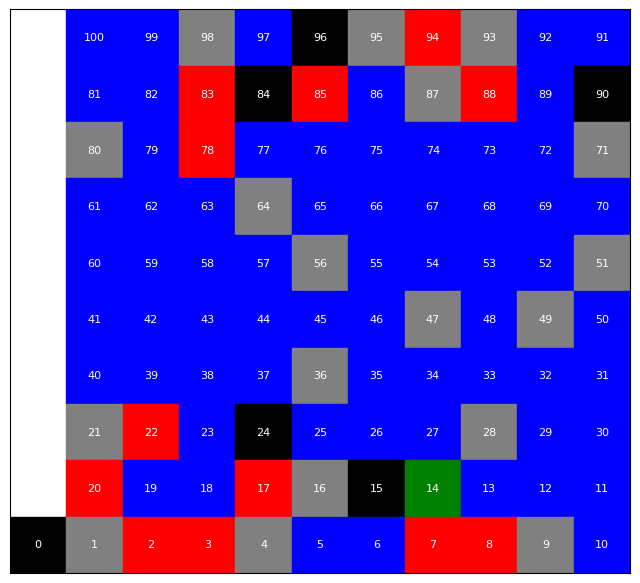

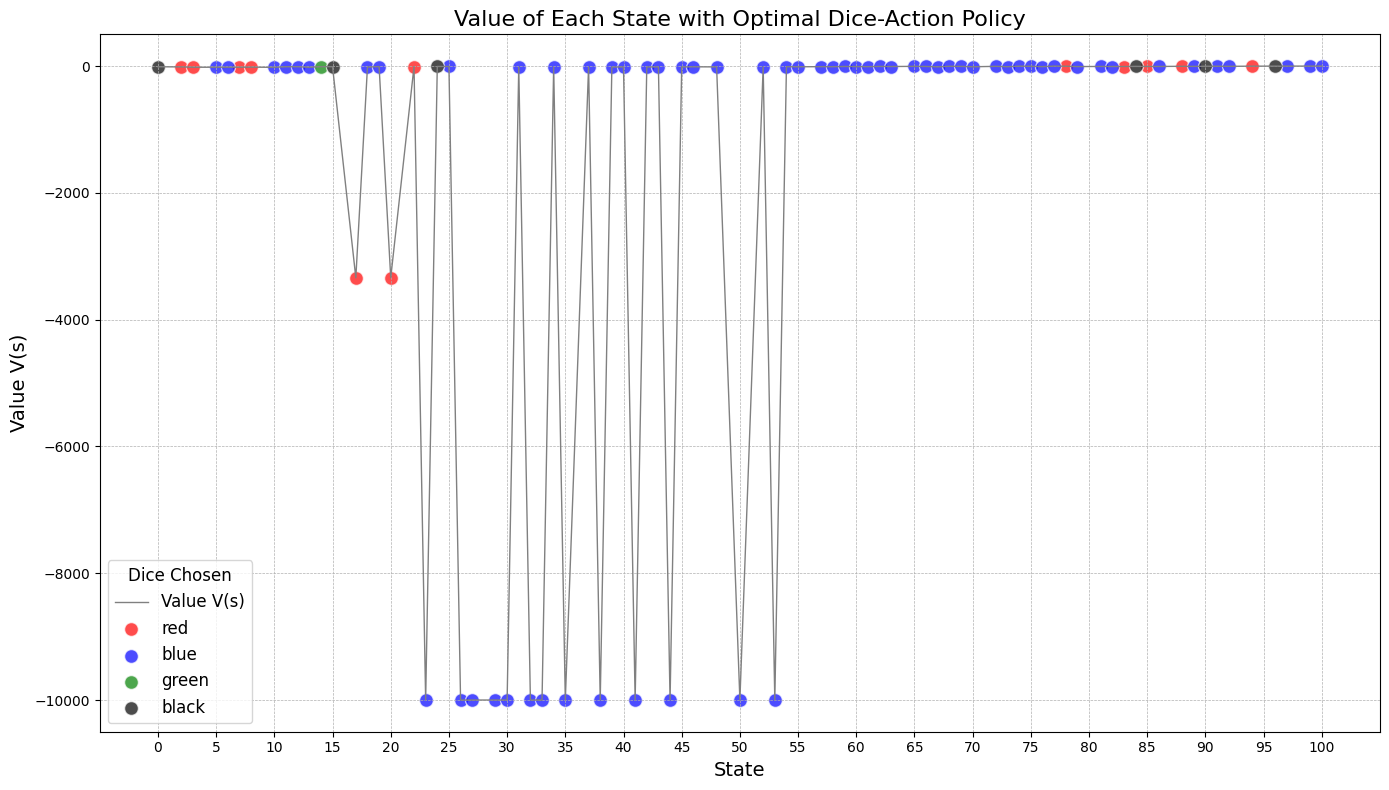

In [48]:
def plot_policy(policy):
    """Takes in a policy dictionary (map from state:action) and draws it on the board"""
    grid = np.zeros((10, 10), dtype=int)
    number = 1
    for row in range(10):
        if row % 2 == 0:
            for col in range(10):
                grid[9 - row, col] = number
                number += 1
        else:
            for col in range(9, -1, -1):
                grid[9 - row, col] = number
                number += 1

    colors = []
    for row in range(10):
        row_colors = []
        for col in range(10):
            cell_number = grid[row, col]
            row_colors.append(policy.get(cell_number, 'grey'))  
        colors.append(row_colors)

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_aspect('equal')

    # starting square at left
    ax.add_patch(
        plt.Rectangle((-1, 9), 1, 1, color=policy.get(0, 'grey'))
    )
    ax.text(-0.5, 9.5, '0', color='white', ha='center', va='center', fontsize=8)

    for row in range(10):
        for col in range(10):
            ax.add_patch(
                plt.Rectangle((col, row), 1, 1, color=colors[row][col])
            )
            ax.text(col + 0.5, row + 0.5, str(grid[row, col]),
                    color='white', ha='center', va='center', fontsize=8)
    
    ax.set_xlim(-1, 10)
    ax.set_ylim(0, 10)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.gca().invert_yaxis()
    plt.show()

# Initialize and improve policy
policy = {s: 'blue' for s in normal_states}

while True:
    better_action = local_search(policy)
    if not better_action:
        break

final_V = matrix(policy)

print("Best Policy")
for s in sorted(policy.keys()):
    print(f"State {s}: Action {policy[s]}")
print("Value of initial state:", final_V[stable_state_to_index[0]])

# Plot the final policy on the board
plot_policy(policy)

color_map = {'red': 'r', 'blue': 'b', 'green': 'g', 'black': 'k'}
sorted_states = sorted(normal_states)
values = [final_V[stable_state_to_index[s]] for s in sorted_states]

states_by_action = {a: [] for a in actions}
values_by_action = {a: [] for a in actions}

for s in sorted_states:
    a = policy[s]
    states_by_action[a].append(s)
    values_by_action[a].append(final_V[stable_state_to_index[s]])

plt.figure(figsize=(14, 8))
plt.plot(sorted_states, values, color='gray', linewidth=1, label='Value V(s)')

for a in actions:
    plt.scatter(states_by_action[a], values_by_action[a], c=color_map[a], 
                label=a, alpha=0.7, edgecolors='w', s=100)

plt.title("Value of Each State with Optimal Dice-Action Policy", fontsize=16)
plt.xlabel("State", fontsize=14)
plt.ylabel("Value V(s)", fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(title="Dice Chosen", fontsize=12, title_fontsize=12)
plt.xticks(range(0, 101, 5))
plt.tight_layout()
plt.show()

In [49]:
def plot_value(data_dict):

    color_data = defaultdict(lambda: defaultdict(list))
    for (integer, color), number in data_dict.items():
        if number != -1 and number != 0:  # skip default values
            color_data[color]['x'].append(integer)
            color_data[color]['y'].append(number)
        # else:
        #     print(integer)

    plt.figure(figsize=(10, 6))

    for color, values in color_data.items():
        x_values = values['x']
        y_values = values['y']

        plt.plot(x_values, y_values, label=color, color=color)

    plt.xlabel('State')
    plt.ylabel('Value')
    plt.title('Value as a function of State given an Action')
    plt.legend(title="Actions")

    plt.show()

def plot_policy(policy):
    """Takes in a policy dictionary (map from state:action) and draws in on the board"""
    grid = np.zeros((10, 10), dtype=int)

    #creates and numbers the base 1-100 grid
    number = 1
    for row in range(10):
        #logic to snake the numbers
        if row % 2 == 0:
            for col in range(10):
                grid[9 - row, col] = number
                number += 1
        else:
            for col in range(9, -1, -1):
                grid[9 - row, col] = number
                number += 1

    #create 2d matrix of colors
    colors = []
    for row in range(10):
        row_colors = []
        for col in range(10):
            cell_number = grid[row, col]
            row_colors.append(policy.get(cell_number, 'grey'))  # Default to grey if not in policy
        colors.append(row_colors)

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_aspect('equal')

    # account for starting square 0. Placed it to the left of the 1st spot outside of the 10x10 grid
    ax.add_patch(
        plt.Rectangle((-1, 9), 1, 1, color=policy.get(0, 'grey'))
    )
    ax.text(
        -0.5, 9.5, '0',
        color='white', ha='center', va='center', fontsize=8
    )

    # actually draw the grid
    for row in range(10):
        for col in range(10):
            ax.add_patch(
                plt.Rectangle((col, row), 1, 1, color=colors[row][col])
            )
            ax.text(
                col + 0.5, row + 0.5, str(grid[row, col]),
                color='white', ha='center', va='center', fontsize=8
            )

    ax.set_xlim(-1, 10)
    ax.set_ylim(0, 10)
    ax.set_xticks([])
    ax.set_yticks([])

    plt.gca().invert_yaxis()
    plt.show()

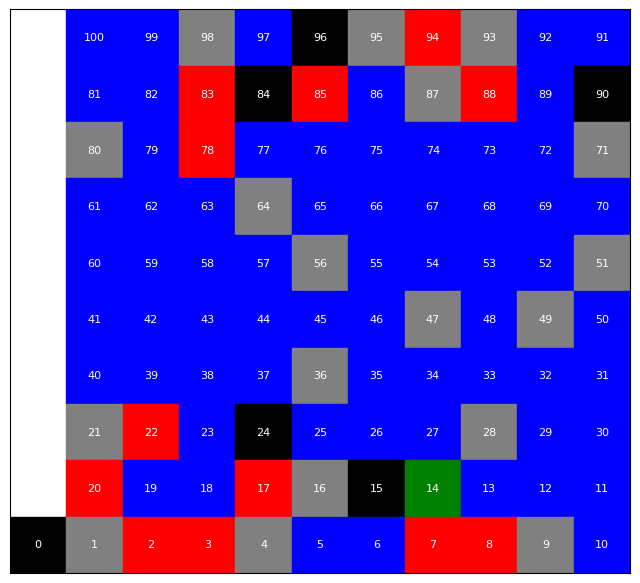

In [50]:
# Initialize and improve policy
policy = {s: 'blue' for s in normal_states}

while True:
    better_action = local_search(policy)
    if not better_action:
        break

final_V = matrix(policy)


plot_policy(policy)